# Multi-layer Perceptron (MLP)

- **Training set**: LO_SARD102
- **Test/Validation set:** JTT
- **Features**: word2vec average
- **Class imbalance processing**: None

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/home/scheuererra68323/venv37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Load labeled dataset

In [2]:
dataset = pd.read_hdf("/mnt/md0/user/scheuererra68323/LO_SARD102/LO_SARD102_word2vec.h5")
testset = pd.read_hdf("/mnt/md0/user/scheuererra68323/JTT/JTT_word2vec.h5")
print(dataset.shape)
print(dataset.is_vulnerable.value_counts())
print()
print(testset.shape)
print(testset.is_vulnerable.value_counts())

(292724, 2)
0.0    269721
1.0     23003
Name: is_vulnerable, dtype: int64

(24999, 2)
0.0    24171
1.0      828
Name: is_vulnerable, dtype: int64


## Prepare train and test datasets

In [4]:
# randomize both datasets
dataset = dataset.sample(frac=1).reset_index(drop=True)
testset = testset.sample(frac=1).reset_index(drop=True)

X_train, X_val, Y_train, Y_val = train_test_split(
    dataset.word2vec_avg,
    dataset.is_vulnerable,
    test_size=0.2,
    stratify=dataset.is_vulnerable,
    random_state=0
)
X_test, Y_test = testset.word2vec_avg, testset.is_vulnerable

X_train = numpy.stack(X_train, axis=0)
Y_train = numpy.stack(Y_train, axis=0)
X_val = numpy.stack(X_val, axis=0)
Y_val = numpy.stack(Y_val, axis=0)
X_test = numpy.stack(X_test, axis=0)
Y_test = numpy.stack(Y_test, axis=0)

print("Training Set:")
print(f"{len(X_train)} total")
print(Counter(Y_train))
print()      
print("Validation Set:")
print(f"{len(X_val)} total")
print(Counter(Y_val))
print()      
print("Test Set:")
print(f"{len(X_test)} total")
print(Counter(Y_test))

Training Set:
234179 total
Counter({0.0: 215777, 1.0: 18402})

Validation Set:
58545 total
Counter({0.0: 53944, 1.0: 4601})

Test Set:
24999 total
Counter({0.0: 24171, 1.0: 828})


## Model definition & Training

In [21]:
init_mode = 'glorot_uniform'
model = keras.Sequential(
    [
        layers.Dense(64,
                     input_dim=100,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),


        layers.Dropout(0.1),

        layers.Dense(64,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),

        layers.Dense(64,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),


        layers.Dense(1, 
                     kernel_initializer=init_mode, 
                     activation=tf.nn.sigmoid),
    ]
)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.03, momentum=0.9, decay=0.001),
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=X_train.shape[0],
                    epochs=60,
                    verbose=True,
                    validation_data=(X_val, Y_val))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0
_________________________________________________________________
Train on 234179 samples, validate on 58545 samples
Epoch 1/60
234179/234179 [==============================] - 1s 4u

Epoch 49/60
234179/234179 [==============================] - 0s 1us/sample - loss: 0.1808 - accuracy: 0.9214 - val_loss: 0.1769 - val_accuracy: 0.9214
Epoch 50/60
234179/234179 [==============================] - 0s 1us/sample - loss: 0.1794 - accuracy: 0.9214 - val_loss: 0.1752 - val_accuracy: 0.9214
Epoch 51/60
234179/234179 [==============================] - 0s 1us/sample - loss: 0.1776 - accuracy: 0.9214 - val_loss: 0.1735 - val_accuracy: 0.9214
Epoch 52/60
234179/234179 [==============================] - 0s 1us/sample - loss: 0.1759 - accuracy: 0.9214 - val_loss: 0.1719 - val_accuracy: 0.9214
Epoch 53/60
234179/234179 [==============================] - 0s 1us/sample - loss: 0.1746 - accuracy: 0.9214 - val_loss: 0.1703 - val_accuracy: 0.9214
Epoch 54/60
234179/234179 [==============================] - 0s 1us/sample - loss: 0.1730 - accuracy: 0.9214 - val_loss: 0.1689 - val_accuracy: 0.9214
Epoch 55/60
234179/234179 [==============================] - 0s 1us/sample - loss: 0.1717 - ac

## Evaluation

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     24171
         1.0       0.00      0.00      0.00       828

    accuracy                           0.97     24999
   macro avg       0.48      0.50      0.49     24999
weighted avg       0.93      0.97      0.95     24999

Confusion matrix:
[[24171     0]
 [  828     0]]

Confusion matrix (Percentages):
[[96.688  0.   ]
 [ 3.312  0.   ]]

Metrics:
Sensitivity (TPR): 0.000000
Specifity (TNR):   1.000000

FPR: 0.000000
FNR: 1.000000

Balanced accuracy: 0.500000

Test loss:	0.188372
Test accuracy:	0.966879


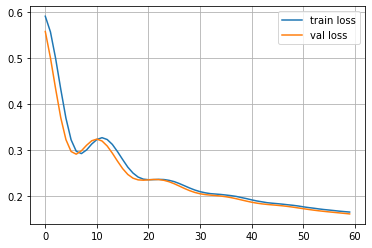

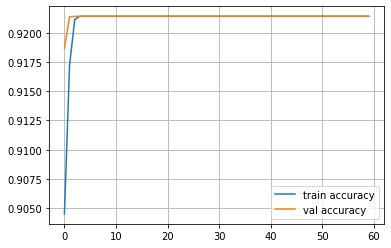

In [22]:
Y_pred = numpy.round(model.predict(X_test))

print(classification_report(Y_test, Y_pred))
print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
print()
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:\t{:.6f}'.format(score[0]))
print('Test accuracy:\t{:.6f}'.format(score[1]))

plot_loss(history)
plot_accuracy(history)

In [7]:
model.save('testJTT_MLP_word2vec')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: testJTT_MLP_word2vec/assets


## Discussion

Prone to getting stuck in local minima (> 50% of runs)